In [1]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# Global plot settings

In [31]:
mpl.rcdefaults()
sns.set_context("notebook")
plt.style.context("default")
plt.style.use("../myStyleSheet.mplstyle")

# Read and prep the raw data

In [3]:
df = pd.read_csv("../data/UVVis-data.csv")

In [4]:
df = df[:-240]

In [5]:
df.head()

Glas   Unnamed: 1           Filter   Unnamed: 3  \
0  Wavelength (nm)           %T  Wavelength (nm)           %T   
1      800.0055542  100.2126312      800.0055542  99.19517517   
2      799.0018311  99.91702271      799.0018311  98.78978729   
3      797.9976807   99.6930542      797.9976807  98.44562531   
4       796.993042  100.4820023       796.993042  98.30296326   

            MgF2_1   Unnamed: 5           MgF2_2   Unnamed: 7  \
0  Wavelength (nm)           %T  Wavelength (nm)           %T   
1      800.0055542  99.45865631      800.0055542  96.34005737   
2      799.0018311  98.86263275      799.0018311  96.03381348   
3      797.9976807  98.43856812      797.9976807  95.47359467   
4       796.993042  98.77004242       796.993042  95.84468842   

            MgF2_3   Unnamed: 9            ZnS_1  Unnamed: 11  \
0  Wavelength (nm)           %T  Wavelength (nm)           %T   
1      800.0055542  100.3763657      800.0055542  75.92430878   
2      799.0018311  100.4560471      799.0018311  76.43289185   
3      797.9976807  99.97418213      797.9976807  76.38736725   
4       796.993042   99.5575943       796.993042  76.01161957   

             ZnS_2  Unnamed: 13            ZnS_3  Unnamed: 15  Unnamed: 16  
0  Wavelength (nm)           %T  Wavelength (nm)           %T          NaN  
1      800.0055542  86.76148987      800.0055542  89.69055939          NaN  
2      799.0018311  87.55351257      799.0018311    89.725914          NaN  
3      797.9976807  87.33820343      797.9976807  89.77655029          NaN  
4       796.993042  87.08116913       796.993042  89.69444275          NaN

In [6]:
def setup_df(df: pd.DataFrame, cols: [int, int], sample: str, repetition: int) -> pd.DataFrame:
    _ = df.iloc[1:, cols]
    _.columns = ["Wavelength / nm", "Transmission / %"]
    _ = _.assign(sample=sample)
    _ = _.assign(repetition=repetition)
    return _

In [7]:
glass = setup_df(df, [0, 1], "glass", 1)

sb_filter = setup_df(df, [2, 3], "filter", 1)

mg_f_1 = setup_df(df, [4, 5], "MgF2", 1)
mg_f_2 = setup_df(df, [6, 7], "MgF2", 2)
mg_f_3 = setup_df(df, [8, 9], "MgF2", 3)

zn_s_1 = setup_df(df, [10, 11], "ZnS", 1)
zn_s_2 = setup_df(df, [12, 13], "ZnS", 2)
zn_s_3 = setup_df(df, [14, 15], "ZnS", 3)

In [8]:
df = pd.concat([glass, sb_filter, mg_f_1, mg_f_2, mg_f_3, zn_s_1, zn_s_2, zn_s_3])

In [9]:
df

Wavelength / nm Transmission / % sample  repetition
1       800.0055542      100.2126312  glass           1
2       799.0018311      99.91702271  glass           1
3       797.9976807       99.6930542  glass           1
4        796.993042      100.4820023  glass           1
5       795.9879761      100.3189697  glass           1
..              ...              ...    ...         ...
597     203.9981689     -170.6767273    ZnS           3
598        203.0112      112.9321594    ZnS           3
599     201.9846802      134.4106903    ZnS           3
600     200.9975891      27.09936142    ZnS           3
601     200.0104065     -353.3028564    ZnS           3

[4808 rows x 4 columns]

In [10]:
set_data_type = {
    "Wavelength / nm" : float,
    "Transmission / %" : float,
    "sample" : object,
    "repetition" : int
}

df = df.astype(set_data_type)

# Glassplättchen Spektrum

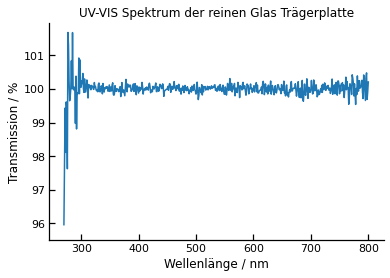

In [11]:
p = df.query("`Wavelength / nm` > 270 and sample == 'glass'")\
    .plot(
    x="Wavelength / nm", y="Transmission / %",
    ylim=(95.5, None),
    ylabel="Transmission / %", xlabel="Wellenlänge / nm", legend=False,
    title="UV-VIS Spektrum der reinen Glas Trägerplatte"
).get_figure()
# p.savefig("../results/spektrum_glasplatte.png", bbox_inches="tight")

# Brechungsindizes exponentieller Fit

In [12]:
refractive_indices = pd.DataFrame.from_dict({
    'MgF2': {
        300: 1.4054,
        400: 1.3959,
        500: 1.3917,
        600: 1.3893,
        700: 1.3878,
        800: 1.3867,
        900: 1.3859,
        1000: 1.3852
    },
    'ZnS': {
        450: 2.473,
        500: 2.419,
        550: 2.386,
        600: 2.363,
        650: 2.345,
        700: 2.332,
        750: 2.322,
        800: 2.313,
        850: 2.306,
        900: 2.301
    }
}).sort_index()

In [13]:
display(refractive_indices)

MgF2    ZnS
300   1.4054    NaN
400   1.3959    NaN
450      NaN  2.473
500   1.3917  2.419
550      NaN  2.386
600   1.3893  2.363
650      NaN  2.345
700   1.3878  2.332
750      NaN  2.322
800   1.3867  2.313
850      NaN  2.306
900   1.3859  2.301
1000  1.3852    NaN

In [14]:
def exponential(x, a, b, c):
    return a * np.exp(-x / b) + c

mgf2_indices = refractive_indices["MgF2"].dropna()
mgf2_fit = curve_fit(
    exponential,
    mgf2_indices.index,
    mgf2_indices.dropna(),
    p0=[0.1, 175, 1.4]
)
mgf2_parameters = mgf2_fit[0]
mgf2_errors = np.sqrt(np.diag(mgf2_fit[1]))

zns_indices = refractive_indices["ZnS"].dropna()
zns_fit = curve_fit(
    exponential,
    zns_indices.index,
    zns_indices.dropna(),
    p0=[3, 160, 2.3]
)
zns_parameters = zns_fit[0]
zns_errors = np.sqrt(np.diag(zns_fit[1]))

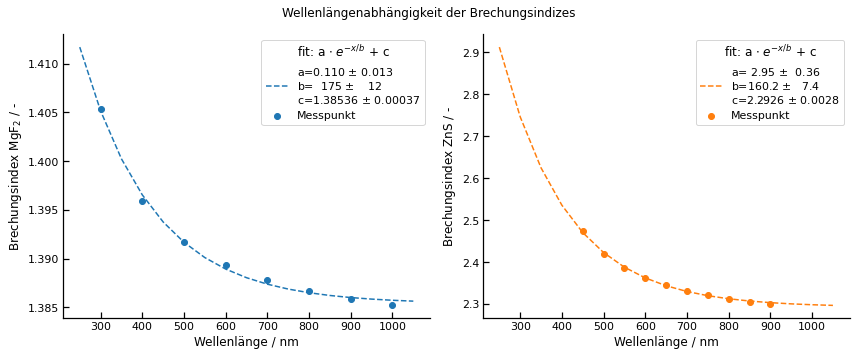

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12, 5))

x_data=np.arange(250, 1_100, 50)
axes[0].plot(
    x_data, exponential(x_data, *mgf2_fit[0]), linestyle="dashed",
    label=fr"a={mgf2_parameters[0]:5.3f} $\pm$ {mgf2_errors[0]:5.3f}" + "\n"
          fr"b={mgf2_parameters[1]:5.0f} $\pm$ {mgf2_errors[1]:5.0f}" + "\n"
          fr"c={mgf2_parameters[2]:5.5f} $\pm$ {mgf2_errors[2]:5.5f}"
)
axes[0].scatter(
    x=refractive_indices.index, y=refractive_indices["MgF2"],
    label="Messpunkt"
)
axes[0].set(
    ylabel=r"Brechungsindex $\mathrm{MgF_2}$ / -",
    xlabel="Wellenlänge / nm"
)
axes[0].legend(title=r"fit: a $\cdot$ $e^{-x / b}$ + c")

axes[1].plot(
    x_data, exponential(x_data, *zns_fit[0]), color="C1", linestyle="dashed",
    label=fr"a={zns_parameters[0]:5.2f} $\pm$ {zns_errors[0]:5.2f}" + "\n"
          fr"b={zns_parameters[1]:5.1f} $\pm$ {zns_errors[1]:5.1f}" + "\n"
          fr"c={zns_parameters[2]:5.4f} $\pm$ {zns_errors[2]:5.4f}"
)
axes[1].scatter(
    x=refractive_indices.index, y=refractive_indices["ZnS"], color="C1",
    label="Messpunkt"
)
axes[1].set(
    ylabel=r"Brechungsindex $\mathrm{ZnS}$ / -",
    xlabel="Wellenlänge / nm"
)
axes[1].legend(title=r"fit: a $\cdot$ $e^{-x / b}$ + c")

fig.suptitle("Wellenlängenabhängigkeit der Brechungsindizes")
plt.tight_layout()
# plt.savefig("../results/brechungsindizes_vs_wellenzahl.png", bbox_inches="tight")

# Kalibrierscichten und Bestimmung der Beugungsordnung etc.

<div class="alert alert-warning">Die erste Messung der ZnS Schicht ist stark von den anderen beiden verschoben.
Daher wurde diese verworfen und der Index der anderen um 1 verringert.</div>

In [16]:
filter_df = df.query("`Wavelength / nm` > 300").groupby("sample").get_group("filter")
zns_df = df.query("`Wavelength / nm` > 300 and repetition != 1").groupby("sample").get_group("ZnS")
zns_df["repetition"] = zns_df["repetition"].apply(lambda x : x - 1)  # easier to rename the measurements than fiddling with the plot legends
mgf2_df = df.query("`Wavelength / nm` > 300").groupby("sample").get_group("MgF2")

In [17]:
def get_peaks(
        dataframe: pd.DataFrame, positive_only: bool, window: int = 1, prominence: int = 1, width: int = 1
) -> pd.DataFrame:
    """Returns a DataFrame with just the Wavelength and Transmission of the datapoints, where peaks were detected"""
    dataframe = dataframe.loc[:, ["Wavelength / nm", "Transmission / %"]].rolling(window).mean()
    pos_peak, _ = find_peaks(dataframe["Transmission / %"], prominence=prominence, width=width)
    if not positive_only:
        neg_peak, _ = find_peaks(-dataframe["Transmission / %"], prominence=prominence, width=width)
    else:
        neg_peak = []
    peaks = np.hstack((pos_peak, neg_peak))
    return dataframe.iloc[peaks][["Wavelength / nm", "Transmission / %"]]

/tmp/ipykernel_632252/3213507290.py:4: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(


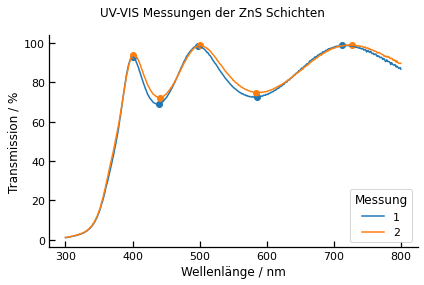

In [18]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # get the matplotlib default colors to override the seaborn palette for consistency

fig, ax = plt.subplots()
sns.lineplot(
    x="Wavelength / nm", y="Transmission / %", data=zns_df,
    hue="repetition", palette=colors, ax=ax
)
plt.legend(title="Messung", loc="lower right")

_1_zns_peaks = get_peaks(zns_df.query("repetition == 1"), positive_only=False)
ax.scatter(x="Wavelength / nm", y="Transmission / %", data=_1_zns_peaks)
_2_zns_peaks = get_peaks(zns_df.query("repetition == 2"), positive_only=False)
ax.scatter(x="Wavelength / nm", y="Transmission / %", data=_2_zns_peaks, color="C1")

ax.set(xlabel="Wellenlänge / nm")
fig.suptitle("UV-VIS Messungen der ZnS Schichten")
plt.tight_layout()
# plt.savefig("../results/zns_uv-vis.png", bbox_inches="tight");

## ZnS Schichtdicke
Konstruktive Interferenz
$$d = \frac{2m \lambda_{max}}{4n} = \frac{m \lambda_{max}}{2n}$$

<br>

Destruktive Interferenz
$$d = (2m + 1) \frac{\lambda_{min}}{4n}$$

In [19]:
_1_zns_peaks = _1_zns_peaks.sort_values("Wavelength / nm").assign(repetition=1)
_2_zns_peaks = _2_zns_peaks.sort_values("Wavelength / nm").assign(repetition=2)

zns_peaks = pd.concat([_1_zns_peaks, _2_zns_peaks]).reset_index(drop=True)

zns_peaks["n / -"] = exponential(zns_peaks["Wavelength / nm"], *zns_parameters)
zns_peaks["m / -"] = [4, 3, 3, 2, 2] * 2  # values taken from the musterprotokoll
zns_peaks["kind"] = ["max", "min", "max", "min", "max"] * 2
maxima = [0, 2, 4, 5, 7, 9]
minima = [1, 3, 6, 8]

zns_peaks.loc[maxima, "d_geom / nm"] = \
    zns_peaks.loc[maxima, "m / -"] * zns_peaks.loc[maxima, "Wavelength / nm"] / (2 * zns_peaks.loc[maxima, "n / -"])
zns_peaks.loc[minima, "d_geom / nm"] = \
    (2 * zns_peaks.loc[minima, "m / -"] + 1) * zns_peaks.loc[minima, "Wavelength / nm"] / (4 * zns_peaks.loc[minima, "n / -"])

display(zns_peaks)

Wavelength / nm  Transmission / %  repetition     n / -  m / - kind  \
0       401.005707         92.874336           1  2.534128      4  max   
1       439.014496         69.085487           1  2.483100      3  min   
2       496.993530         98.571053           1  2.425237      3  max   
3       586.013245         72.485130           1  2.368676      2  min   
4       712.002502         98.903236           1  2.327236      2  max   
5       401.005707         94.064072           2  2.534128      4  max   
6       441.005920         72.322151           2  2.480746      3  min   
7       501.006622         98.832680           2  2.421955      3  max   
8       584.009338         74.765404           2  2.369634      2  min   
9       727.013306         99.112007           2  2.324137      2  max   

   d_geom / nm  
0   316.484181  
1   309.401690  
2   307.388630  
3   309.251495  
4   305.943360  
5   316.484181  
6   311.100121  
7   310.290680  
8   308.069397  
9   312.810065

/tmp/ipykernel_632252/594129467.py:4: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(x="Wavelength / nm", y="Transmission / %", hue="repetition", data=mgf2_df, palette=colors, ax=ax, zorder=-1)  # zorder sets the lineplot in the background


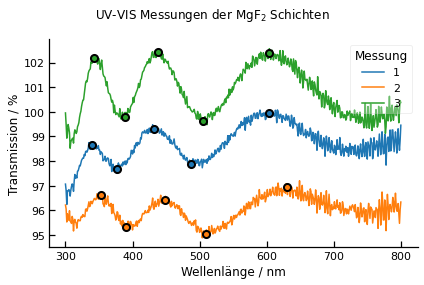

In [20]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # get the matplotlib default colors to override the seaborn palette for consistency

fig, ax = plt.subplots()
sns.lineplot(x="Wavelength / nm", y="Transmission / %", hue="repetition", data=mgf2_df, palette=colors, ax=ax, zorder=-1)  # zorder sets the lineplot in the background

_1_mgf2_peaks = get_peaks(mgf2_df.query("repetition == 1"), positive_only=False, window=4, prominence=1, width=20)
ax.scatter(_1_mgf2_peaks["Wavelength / nm"], _1_mgf2_peaks["Transmission / %"],
           s=50, marker="o", color="C0", edgecolors="k", linewidths=2)
_2_mgf2_peaks = get_peaks(mgf2_df.query("repetition == 2"), positive_only=False, window=4, prominence=1, width=20)
ax.scatter(_2_mgf2_peaks["Wavelength / nm"], _2_mgf2_peaks["Transmission / %"],
           s=50, marker="o", color="C1", edgecolors="k", linewidths=2)
_3_mgf2_peaks = get_peaks(mgf2_df.query("repetition == 3"), positive_only=False, window=4, prominence=1, width=20)
ax.scatter(_3_mgf2_peaks["Wavelength / nm"], _3_mgf2_peaks["Transmission / %"],
           s=50, marker="o", color="C2", edgecolors="k", linewidths=2)

ax.set(xlabel="Wellenlänge / nm")
ax.legend(title="Messung", framealpha=0.3)
fig.suptitle(r"UV-VIS Messungen der $\mathrm{MgF_2}$ Schichten")
plt.tight_layout()
# plt.savefig("../results/mgf2_uv-vis.png", bbox_inches="tight");

## $\mathrm{MgF_2}$ Schichtdicke
Konstruktive Interferenz
$$d = (2m - 1)\frac{\lambda_{max}}{4n}$$

<br>

Destruktive Interferenz
$$d = \frac{2m \lambda_{min}}{4n} = \frac{m\lambda_{min}}{2n}$$

In [21]:
_1_mgf2_peaks = _1_mgf2_peaks.sort_values("Wavelength / nm").assign(repetition=1)
_2_mgf2_peaks = _2_mgf2_peaks.sort_values("Wavelength / nm").assign(repetition=2)
_3_mgf2_peaks = _3_mgf2_peaks.sort_values("Wavelength / nm").assign(repetition=3)

mgf2_peaks = pd.concat([_1_mgf2_peaks, _2_mgf2_peaks, _3_mgf2_peaks]).reset_index(drop=True)

mgf2_peaks["n / -"] = exponential(mgf2_peaks["Wavelength / nm"], *mgf2_parameters)
mgf2_peaks["m / -"] = [5, 4, 4, 3, 3] * 3  # values taken from the musterprotokoll
mgf2_peaks["kind"] = ["max", "min", "max", "min", "max"] * 3
maxima = [0, 2, 4, 5, 7, 9, 10, 12, 14]
minima = [1, 3, 6, 8, 11, 13]

mgf2_peaks.loc[maxima, "d_geom / nm"] = \
    (2 * mgf2_peaks.loc[maxima, "m / -"] - 1) * mgf2_peaks.loc[maxima, "Wavelength / nm"] / (4 * mgf2_peaks.loc[maxima, "n / -"])
mgf2_peaks.loc[minima, "d_geom / nm"] = \
    mgf2_peaks.loc[minima, "m / -"] * mgf2_peaks.loc[minima, "Wavelength / nm"] / (2 * mgf2_peaks.loc[minima, "n / -"])

display(mgf2_peaks)

Wavelength / nm  Transmission / %  repetition     n / -  m / - kind  \
0        339.500839         98.673174           1  1.401156      5  max   
1        376.504555         97.666927           1  1.398146      4  min   
2        431.501656         99.320784           1  1.394698      4  max   
3        487.496452         97.897392           1  1.392142      3  min   
4        603.502716         99.953974           1  1.388856      3  max   
5        352.504463         96.609184           2  1.400025      5  max   
6        390.509842         95.321932           2  1.397162      4  min   
7        448.505669         96.437834           2  1.393834      4  max   
8        509.494560         95.046452           2  1.391341      3  min   
9        630.500748         96.936617           2  1.388356      3  max   
10       342.496254        102.175076           3  1.400888      5  max   
11       388.501289         99.791548           3  1.397299      4  min   
12       437.501167        102.416992           3  1.394383      4  max   
13       505.498161         99.611454           3  1.391479      3  min   
14       603.502716        102.371857           3  1.388856      3  max   

    d_geom / nm  
0    545.176100  
1    538.576963  
2    541.427498  
3    525.266056  
4    543.165335  
5    566.514887  
6    559.004188  
7    563.112363  
8    549.284481  
9    567.668284  
10   550.091429  
11   556.074780  
12   549.079276  
13   544.921887  
14   543.165335

# Schmalbandfilter

/tmp/ipykernel_632252/781072508.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x="Wavelength / nm", y="Transmission / %", data=filter_df,


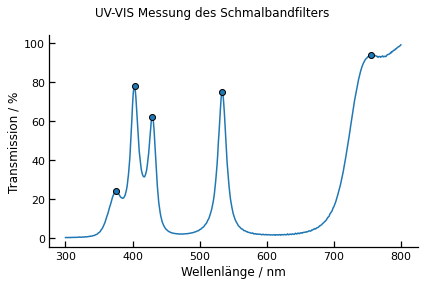

In [22]:
filter_peak_positions, peak_parameters = find_peaks(filter_df["Transmission / %"], prominence=1, width=8)
filter_peaks = filter_df.iloc[filter_peak_positions][["Wavelength / nm", "Transmission / %"]]

fig, ax = plt.subplots()
sns.lineplot(x="Wavelength / nm", y="Transmission / %", data=filter_df,
             palette=colors, legend=False, ax=ax, zorder=-1)
ax.scatter(x=filter_peaks["Wavelength / nm"], y=filter_peaks["Transmission / %"], edgecolors="k", linewidths=1)
ax.set(xlabel="Wellenlänge / nm")
fig.suptitle("UV-VIS Messung des Schmalbandfilters")
plt.tight_layout()
# plt.savefig("../results/filter_uv-vis.png", bbox_inches="tight");

In [23]:
filter_main_peak = filter_df.query("480 < `Wavelength / nm` < 590").reset_index()
filter_main_peak.plot(x="Wavelength / nm", y="Transmission / %");

In [24]:
from lmfit.models import LorentzianModel
model = LorentzianModel()
params = model.guess(
    filter_main_peak["Transmission / %"],
    x=filter_main_peak["Wavelength / nm"]
)
result = model.fit(
    filter_main_peak["Transmission / %"],
    params,
    x=filter_main_peak["Wavelength / nm"]
)
result

<div class="alert alert-info">leastsq = Levenberg Marquardt minimization algorithm <a href="https://lmfit.github.io/lmfit-py/fitting.html">(see lmfit documentation)</a>

In [33]:
fig, ax = plt.subplots()
ax.scatter(
    filter_main_peak["Wavelength / nm"],
    filter_main_peak["Transmission / %"],
    label="Messpunkt"
)
amplitude = result.params["amplitude"]
center = result.params["center"]
sigma = result.params["sigma"]
FWHM = result.params["fwhm"]
height = result.params["height"]
ax.plot(
    filter_main_peak["Wavelength / nm"], result.best_fit,
    color="C1", linestyle="--",
    label=fr'A={amplitude.value:5.2f} $\pm$ {amplitude.stderr:5.2f}' + "\n" +
          fr"$\mu$={center.value:5.3f} $\pm$ {center.stderr:5.3f}" + "\n" +
          fr"$\sigma$={sigma.value:5.3f} $\pm$ {sigma.stderr:5.3f}" + "\n" +
          fr"$R^2$={result.rsquared:5.4f}"
)
ax.set(
    xlabel="Wellenlänge / nm",
    ylabel="Transmission / %"
)
ax.text(
    x=480, y=58,
    s="Peak\n" + fr"FWHM={FWHM.value:5.3f} $\pm$ {FWHM.stderr:5.3f}" + "\n" +
      fr"Höhe={height.value:5.2f} $\pm$ {height.stderr:5.2f}" + "\n" +
      fr"$\lambda$=$\mu$={center.value:5.3f} $\pm$ {center.stderr:5.3f}",
    bbox={"boxstyle": "round", "fill": False, "color": "lightgray"}
)
ax.axvline(534, 0, 1, color="grey", linestyle="dotted")
plt.legend(
    title="Lorentz fit:\n" +
          r"$f(x;A,\mu,\sigma) = \frac{A}{\pi}[\frac{\sigma}{(x - \mu)^2 + \sigma^2}$]",
)
fig.suptitle("Transmissionsmaximum des Schmalbandfilters")
plt.tight_layout()
plt.savefig("../results/filter_peak_fit.png", bbox_inches="tight")
None

# Ellipsometrie

In [34]:
data_ellipso = pd.read_csv('../data/Ellipsometrie-Daten.csv', names=['psi', 'delta', 'dicke', 'probe'], skiprows=1)
data_ellipso

psi     delta     dicke                  probe
0   28.8479  175.8536    5.2826  SiO2-Schichten auf Si
1   29.0279  162.8210   23.0023  SiO2-Schichten auf Si
2   31.0877  144.2351   51.4055  SiO2-Schichten auf Si
3   33.9705  133.7574   72.7511  SiO2-Schichten auf Si
4   39.7496  128.3295   92.0783  SiO2-Schichten auf Si
5   45.7468  130.2244  103.0242  SiO2-Schichten auf Si
6   29.5879  196.2043  238.0943  SiO2-Schichten auf Si
7   31.6750  222.8127  197.2465  SiO2-Schichten auf Si
8   55.5865  217.5981  144.2024  SiO2-Schichten auf Si
9   42.7681  129.0558   98.1570  SiO2-Schichten auf Si
10  30.8323  146.1734   48.1613  SiO2-Schichten auf Si
11  26.6578  192.6065    1.2458    Cu-Schichten auf Si
12  36.1529  167.9747   11.3257    Cu-Schichten auf Si
13  40.5495  147.5130   25.6165    Cu-Schichten auf Si
14  40.8345  133.7104   22.4372    Cu-Schichten auf Si
15  42.0260  129.6089   21.2457    Cu-Schichten auf Si
16  41.5886  130.7363   24.9721    Cu-Schichten auf Si
17  29.5510  175.9557   56.1475    Cu-Schichten auf Si

In [35]:
class Labels:
    mess = 'Messpunkte'
    psi = '$\Psi$ / $^\circ$'
    delta = '$\Delta$ / $^\circ$'
    ellipso = 'Ellipsometriemessung von {von} auf Si'

In [37]:
fig, ax = plt.subplots()
ax.scatter('delta', 'psi', data=data_ellipso.query('probe=="SiO2-Schichten auf Si"'), label=Labels.mess)
ax.legend(loc=9)
ax.set_xlabel(Labels.delta)
ax.set_ylabel(Labels.psi)
ax.set_title(Labels.ellipso.format(von='SiO$_2$'))
plt.tight_layout()
plt.savefig("../results/ellipso_sio2.png", bbox_inches="tight");

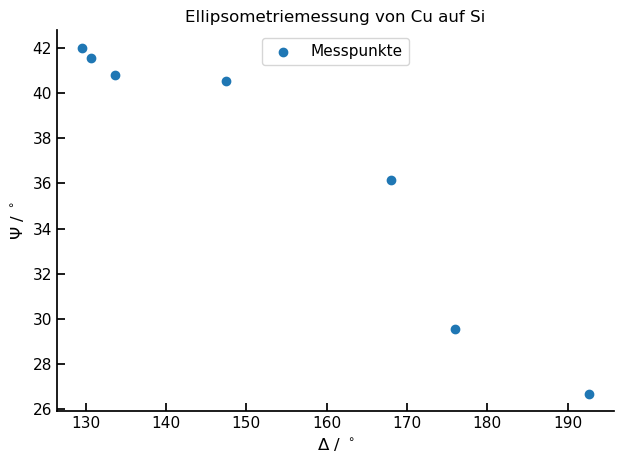

In [38]:
fig, ax = plt.subplots()
ax.scatter('delta', 'psi', data=data_ellipso.query('probe=="Cu-Schichten auf Si"'), label=Labels.mess)
ax.legend(loc=9)
ax.set_xlabel(Labels.delta)
ax.set_ylabel(Labels.psi)
ax.set_title(Labels.ellipso.format(von='Cu'))
plt.tight_layout()
plt.savefig("../results/ellipso_cu.png", bbox_inches="tight");